# Capstone Project – Battle of the neighbourhoods
## Compare cities in the Netherlands 

## Table of content
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Data Cleaning](#datacleaning)
* [Methodology](#method)
* [Result](#result)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

The Netherlands is a densely populated country. This results in a lack of affordable houses in different cities. As space is scarce the prices for houses is increasing in those areas. People often live in houses that are smaller than they are comfortable with because they like the city for the restaurants and bars.  The current pandemic however has shown people that they can work from home and do not need to live close by their offices. This opens opportunities as the Netherlands is also a small country where distances are a matter of hours driving maximum.
Would it not be great to compare the city that you live in with other cities in the Netherlands based on same comfort in restaurants and bars but with a lower housing price?  

This project aims to cluster the cities in the Netherlands based on restaurants and bars and then rank them within their cluster based on the square meter price for houses. This will then provide the needed information. You can search on your city within the list and then check which group your city belongs to. Then you will be able to see in the group what cities are cheaper then your own city.


## Data <a name="data"></a>

The data that is needed to answer the question on comparable cities with lower house prices:
* A list of biggest cities in the Netherlands
* The latitude and Longitude of those cities
* The square meter price for houses
* The categories of interest on which to compare the cities

A list of the biggest cities in the Netherlands can be retrieved from https://wikikids.nl/Lijst_van_grote_Nederlandse_steden. This site holds a list with all cities with more than 50.000 residents plus one other city (Middelburg) as that is the capital of a county (Zeeland).

The latitude and longitude can be added to this list by using openstreetmap data which is accessed via GeoPy geocoder Nominatim.

The square meter sales prices for houses can be found on HuizenZoeker.nl. An excel file with information on prices including the house prices per square meters over the last years can be retrieved from https://www.huizenzoeker.nl/woningmarkt/download/woningmarkt-gemeenten.xls?d=20210221. It holds the prices for each month. In this project the data from January 2021 will be used.

The categories on which the data will be grouped can be found on https://developer.foursquare.com/docs/build-with-foursquare/categories/. In this project the focus will be on restaurants and pubs. The restaurants are specified in more detail to search for Cajun, Creole, Indonesian and mediterranean cuisine.

The cities will be compared based on the top 15 categories that are returned by foursquare.

## Data Cleaning <a name="datacleaning"></a>

The data in the different list can be combined but some of it is not used in this project. There are four cities listed in list of biggest cities that does not match the list of housing prices. This due to different ways of entering this data. The four cities that will be changed to match the data are: 
* "'s-Gravenhage" which is also known as "Den Haag" => "Den Haag" will be used as city name. 
* "'s-Hertogenbosch" which is also known as "Den Bosch" => "Den Bosch" will be used as city name.
* "Spijkenisse" is named in the list of cities but the municipal "Nissewaard" is mentioned in the list with prices. => "Spijkenisse" will be used as city name.
* "Hengelo" is listed as "Hengelo (O)"in the list with house prices. => "Hengelo" will be used as city name.
* "Westland" is the municipal but the biggest city has only 17.000 residents so this will not be considered and is dropped.

The list of house prices contains data in different sheets and with different columns. In this project the average house price per square meter (Gem. vraagprijs per m2) will be used from the month January 2021.

### Cities in the Netherlands

First a dataframe with the biggest cities will be created. This data will be enhanced with latitude and longitude and with the square meter price for houses.

Import all dependencies

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from sklearn.cluster import KMeans # import k-means for clustering
import math #import math for calculations
import folium #use for creating a map
import matplotlib.cm as cm #color on map
import matplotlib.colors as colors #color on map

#### Scrape list of biggest cities of the Netherlands

A dataframe with the biggest cities of the Netherlands is created. \
The Number column, the inwoners (residents) column and the column containing pictures are dropped as they are not needed for analysis.\
The column names are translated into English.

In [2]:
#define the url
url = 'https://wikikids.nl/Lijst_van_grote_Nederlandse_steden'
# read data from website into dataframe
dfs = pd.read_html(url)
# Get the table with cities                                                                                                           
df = dfs[1]
df.drop(['Nº', 'Inwoners', 'Stadsbeeld'],axis=1,inplace=True)
df.rename(columns = {'Naam':'City', 'Provincie':'County'},inplace=True)
df.head()

,City,County
0,Amsterdam,Noord-Holland
1,Rotterdam,Zuid-Holland
2,Den Haag,Zuid-Holland
3,Utrecht,Utrecht
4,Eindhoven,Noord-Brabant


#### Add the coordinates to the list
Now the latitude and longitude need to be added to the list. To accomplies this a function is created to fetch the latitude and longitude for a given city. This function will be called with the dataframe containing the biggest cities. 

In [3]:
def AddLonLat(Cities, Counties):
    
    city_list=[]
    for City, County in zip(Cities, Counties):
        # Get the latitude and longitude
        geolocator = Nominatim(user_agent="NL_explorer")
        location = geolocator.geocode(City)
        latitude = location.latitude
        longitude = location.longitude
        city_list.append([(
            City,
            County, 
            latitude, 
            longitude)])
    Dutch_Cities = pd.DataFrame([item for city_list in city_list for item in city_list])
    Dutch_Cities.columns = ['City',
                  'County', 
                  'Latitude', 
                  'Longitude'] 
    return(Dutch_Cities)

Call the function to create the new dataframe holding all the information.

In [5]:
df.iat[17,0] = 'Den Bosch' # 's-Hertogenbosch is also known as Den Bosch
df.drop(25, inplace = True) # 'Westland is a municipal but the biggest city only has 17.000 residents
Biggest_Dutch_Cities = AddLonLat(Cities=df['City'], Counties=df['County'])
Biggest_Dutch_Cities.head()

,City,County,Latitude,Longitude
0,Amsterdam,Noord-Holland,52.372760,4.893604
1,Rotterdam,Zuid-Holland,51.922893,4.463179
2,Den Haag,Zuid-Holland,52.079984,4.311346
3,Utrecht,Utrecht,52.080986,5.127684
4,Eindhoven,Noord-Brabant,51.439265,5.478633


#### Add the average house prices per square meter from January 2021 
Next the information about the prices per square meters need to be added. This excell file has been retrieved from HuizenZoeker.nl. Then the correct column will be added to the dataframe to complete the data

In [6]:
# Read the excell sheet from HuizenZoeker.nl
City_prices = pd.read_excel('https://www.huizenzoeker.nl/woningmarkt/download/woningmarkt-gemeenten.xls?d=20210221', sheet_name = 'Gem. vraagprijs per m2')
City_prices.head()

,Gemeente,Sep 2008,Okt 2008,Nov 2008,Dec 2008,Jan 2009,Feb 2009,Mrt 2009,Apr 2009,Mei 2009,...,Apr 2020,Mei 2020,Jun 2020,Jul 2020,Aug 2020,Sep 2020,Okt 2020,Nov 2020,Dec 2020,Jan 2021
0,'s-Gravenhage,2251,2263,2289,2270,2271,2278,2295,2308,2313,...,3451,3433,3469,3476,3481,3495,3490,3517,3543,3595
1,'s-Hertogenbosch,2533,2540,2544,2535,2535,2520,2509,2506,2514,...,3241,3236,3213,3259,3219,3251,3315,3348,3403,3436
2,Aa en Hunze,2404,2408,2418,2422,2418,2421,2373,2343,2331,...,2298,2331,2370,2338,2402,2438,2431,2451,2374,2460
3,Aalburg,2788,2874,2859,2878,2843,2792,2657,2603,2612,...,2745,2745,2768,2734,2731,2730,2717,2725,2718,2820
4,Aalsmeer,3087,3096,3090,3075,3046,3048,3033,3023,3034,...,3699,3814,3870,3928,3987,4057,4001,3942,3973,3996


Combine the prices from January with the Biggest City dataframe

In [7]:
Jan_City_price = City_prices[['Gemeente','Jan 2021']]
Jan_City_price.iat[0,0] = 'Den Haag' # 's-Gravenhage is also known as Den Haag
Jan_City_price.iat[1,0] = 'Den Bosch' # 's-Hertogenbosch is also known as Den Bosch
Jan_City_price.iat[273,0] = 'Spijkenisse' # Nissewaard is the municipal but Spijkenisse is the City
Jan_City_price.iat[172,0] = 'Hengelo' # 'Hengelo (O)' replaced by 'Hengelo' 
Jan_City_price.head()
Biggest_Dutch_Cities = Biggest_Dutch_Cities.join(Jan_City_price.set_index('Gemeente'), on='City')
Biggest_Dutch_Cities.rename(columns = {'Jan 2021':'Avg Price per Square Meter'},inplace=True)
Biggest_Dutch_Cities.head()

,City,County,Latitude,Longitude,Avg Price per Square Meter
0,Amsterdam,Noord-Holland,52.372760,4.893604,6200
1,Rotterdam,Zuid-Holland,51.922893,4.463179,3596
2,Den Haag,Zuid-Holland,52.079984,4.311346,3595
3,Utrecht,Utrecht,52.080986,5.127684,4163
4,Eindhoven,Noord-Brabant,51.439265,5.478633,3289


The base information with which the next step can start is now complete.

#### Foursquare data

The next step is to add the foursquare data of each city. \
The foursquare API returns a limited number of venues per call. As multiple categories are investigated multiple calls will be made to get the more results per category. The categories used in this project are Cajun, Falafal, Indonesian, Mediteranian, Lebanese, Spanish, Greek, Italian, Turkish and Pub.

In [8]:
CLIENT_ID = 'Foursquare ID'
CLIENT_SECRET = 'Foursquare Secret'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value


In [9]:
def getCityVenues(Cities, latitudes, longitudes, radius=5000):
    # Cajun 4bf58dd8d48988d17a941735
    # Falafal 4bf58dd8d48988d10b941735
    # Indonesian 4deefc054765f83613cdba6f
    # Mediteranian 4bf58dd8d48988d1c0941735
    # Lebanese 58daa1558bbb0b01f18ec1cd
    # Spanish 4bf58dd8d48988d150941735
    # Greek 4bf58dd8d48988d10e941735
    # Italian 4bf58dd8d48988d110941735
    # Turkish 4f04af1f2fb6e1c99f3db0bb
    # Pub 4bf58dd8d48988d11b941735
    Categories = ['4bf58dd8d48988d17a941735', 
                  '4bf58dd8d48988d10b941735', 
                  '4deefc054765f83613cdba6f', 
                  '4bf58dd8d48988d1c0941735', 
                  '58daa1558bbb0b01f18ec1cd', 
                  '4bf58dd8d48988d150941735', 
                  '4bf58dd8d48988d10e941735',
                  '4bf58dd8d48988d110941735',
                  '4f04af1f2fb6e1c99f3db0bb',
                  '4bf58dd8d48988d11b941735']
    venues_list=[]
    for City, lat, lng in zip(Cities, latitudes, longitudes):
        for category in Categories: 
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT,
                category)

            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            #results = requests.get(url).json()["response"]['venues']

            # return only relevant information for each nearby venue
            venues_list.append([(
                City,
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

    City_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    City_venues.columns = ['City',
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(City_venues)

In [10]:
Dutch_City_venues = getCityVenues(Cities = Biggest_Dutch_Cities['City'], latitudes = Biggest_Dutch_Cities['Latitude'], longitudes = Biggest_Dutch_Cities['Longitude'])

As we queried foursquare on different categories we must remove the duplicates as there might be overlapping results

In [11]:
Dutch_City_venues.shape

(3324, 7)

In [12]:
Dutch_City_venues.drop_duplicates(subset=['City', 'Venue', 'Venue Latitude', 'Venue Longitude'], keep='last', inplace = True)
Dutch_City_venues.shape

(3202, 7)

The dataframe now holds all venues within the selected categories for the selected cities. The data will now be converted in the next step to hold one record per city with the sume of every different venue category.  

In [14]:
City_Categories = pd.get_dummies(Dutch_City_venues[['Venue Category']], prefix="", prefix_sep="")

City_Categories['City'] = Dutch_City_venues['City']

fixed_columns = [City_Categories.columns[-1]] + list(City_Categories.columns[:-1])
City_Categories = City_Categories[fixed_columns]
City_Cat_Grouped = City_Categories.groupby('City').mean().reset_index()
City_Cat_Grouped

,City,Argentinian Restaurant,Asian Restaurant,Bagel Shop,Bakery,Balinese Restaurant,Bar,Bed & Breakfast,Beer Bar,Beer Garden,...,Tapas Restaurant,Tea Room,Theme Restaurant,Trattoria/Osteria,Turkish Home Cooking Restaurant,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop
0,Alkmaar,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.500000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,Almelo,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.142857,0.0,0.0,0.0,0.0,0.238095,0.0,0.0,0.000000,0.0
2,Almere,0.0,0.032258,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.064516,0.0,0.0,0.0,0.0,0.096774,0.0,0.0,0.000000,0.0
3,Alphen aan den Rijn,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.032258,0.0,0.0,0.0,0.0,0.129032,0.0,0.0,0.000000,0.0
4,Amersfoort,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.057692,0.0,0.0,0.0,0.0,0.057692,0.0,0.0,0.019231,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,Vlaardingen,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.041667,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.000000,0.0
58,Zaanstad,0.0,0.000000,0.0,0.0,0.0,0.028571,0.0,0.0,0.0,...,0.057143,0.0,0.0,0.0,0.0,0.057143,0.0,0.0,0.000000,0.0
59,Zeist,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.043478,0.0,0.0,0.0,0.0,0.130435,0.0,0.0,0.000000,0.0
60,Zoetermeer,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.076923,0.0,0.0,0.0,0.0,0.115385,0.0,0.0,0.000000,0.0


To compare the cities based on venues the top 15 venue categiories will be selected per city in the next steps.

In [15]:
def return_topX_venues(row, NumberOfVenues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:NumberOfVenues]

In [16]:
TopXVenues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(TopXVenues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Cities_venues_sorted = pd.DataFrame(columns=columns)
Cities_venues_sorted['City'] = City_Cat_Grouped['City']

for ind in np.arange(City_Cat_Grouped.shape[0]):
    Cities_venues_sorted.iloc[ind, 1:] = return_topX_venues(City_Cat_Grouped.iloc[ind, :], TopXVenues)

Cities_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alkmaar,Italian Restaurant,Tapas Restaurant,Wine Shop,Fast Food Restaurant,Cuban Restaurant,Deli / Bodega,Dessert Shop,Diner,Doner Restaurant,Eastern European Restaurant
1,Almelo,Turkish Restaurant,Italian Restaurant,Indonesian Restaurant,Pub,Tapas Restaurant,Doner Restaurant,Falafel Restaurant,Greek Restaurant,Food Court,Food Stand
2,Almere,Italian Restaurant,Doner Restaurant,Greek Restaurant,Turkish Restaurant,Mediterranean Restaurant,Falafel Restaurant,Indonesian Restaurant,Tapas Restaurant,Spanish Restaurant,Asian Restaurant
3,Alphen aan den Rijn,Greek Restaurant,Pub,Italian Restaurant,Turkish Restaurant,Indonesian Restaurant,Spanish Restaurant,Mediterranean Restaurant,Cajun / Creole Restaurant,Doner Restaurant,Falafel Restaurant
4,Amersfoort,Italian Restaurant,Indonesian Restaurant,Pub,Restaurant,Greek Restaurant,Tapas Restaurant,Turkish Restaurant,Falafel Restaurant,Mediterranean Restaurant,Burger Joint


## Methodology <a name="method"></a>

In this project we will focus on detecting similarity between cities based on restaurants and bars. We will limit our analysis to an area ~5km around the city center.

In first step we have collected the required **data: location, average house prices per square meters and category of the restaurants and bars within 5km from the city center** (according to Foursquare categorization). We have created an overview of the top 15 categories for the biggest cities in the Netherlands.

Second step in our analysis will be the use of unsupervised clustering by means of the **k-means clustering**. To be able to use this method we will need to identify the optimal number of clusters. This will be done with the elbow method.


First steps is to define a function to run the K-means with different parameters. Then the outcome of these runs will be plotted to show the result. Based on the plotted data we should be able to use the elbow method to define the optimal number of clusters.

In [17]:
 def calculate_SumOfSquaresWithinCluster(data):
        sswc = []
        for n in range(2, 21):
            kmeans = KMeans(n_clusters=n).fit(data)
            sswc.append(kmeans.inertia_)
        return sswc

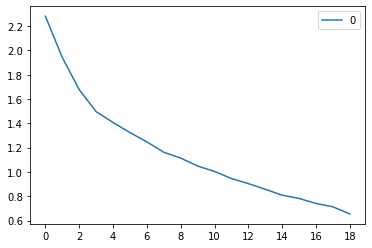

In [18]:
City_Cat_Grouped_Clustering = City_Cat_Grouped.drop('City', 1)
SumOfSquares = calculate_SumOfSquaresWithinCluster(City_Cat_Grouped_Clustering)
pd.DataFrame(SumOfSquares).plot(xticks= [0,2,4,6,8,10,12,14,16,18])

Unfortunately the elbow method is not easy to apply by just looking at the plot. The optimal number of clusters will therefor be determined with a function in the next steps. It is the point with the maximum distance from the straight line.

In [19]:
def optimal_number_of_clusters(sswc):
    x1, y1 = 2, sswc[0] # the first run was with 2 clusters
    x2, y2 = 20, sswc[len(sswc)-1] # 20 was the maximum number of clusters
    # (x1, y1) to (x2, y2) is a straight line. The best number of clusters is the one that has the most distance to that line (elbow point)
    distances = []
    for i in range(len(sswc)):
        x0 = i+2 # the first run was with 2 clusters
        y0 = sswc[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2 # the first run was with 2 clusters

In [20]:
n = optimal_number_of_clusters(SumOfSquares)
print('The optimal number of clusters is {}'.format(n))

The optimal number of clusters is 5


Now this optimal number of clusters can be used to create the clusters. The clusters are then grouped per cluster and sorted on the average price per square meter.

In [21]:
# set number of clusters
kclusters = n
City_Cat_Grouped_Clustering = City_Cat_Grouped.drop('City', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(City_Cat_Grouped_Clustering)

# check cluster labels generated for rows in the dataframe
kmeans.labels_[0:15] 

array([4, 2, 1, 1, 1, 1, 1, 2, 0, 1, 2, 0, 1, 0, 0])

In [22]:
# add clustering labels
Cities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

City_merged = Biggest_Dutch_Cities

# merge to add 
City_merged = City_merged.join(Cities_venues_sorted.set_index('City'), on='City')

City_merged.head() 

,City,County,Latitude,Longitude,Avg Price per Square Meter,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amsterdam,Noord-Holland,52.372760,4.893604,6200,1,Italian Restaurant,Indonesian Restaurant,Pub,Turkish Restaurant,Bar,Mediterranean Restaurant,Falafel Restaurant,Tapas Restaurant,Greek Restaurant,Spanish Restaurant
1,Rotterdam,Zuid-Holland,51.922893,4.463179,3596,2,Italian Restaurant,Turkish Restaurant,Pub,Mediterranean Restaurant,Indonesian Restaurant,Tapas Restaurant,Bar,Spanish Restaurant,Greek Restaurant,Doner Restaurant
2,Den Haag,Zuid-Holland,52.079984,4.311346,3595,1,Italian Restaurant,Indonesian Restaurant,Mediterranean Restaurant,Pub,Turkish Restaurant,Greek Restaurant,Spanish Restaurant,Bar,Tapas Restaurant,Falafel Restaurant
3,Utrecht,Utrecht,52.080986,5.127684,4163,0,Italian Restaurant,Pub,Greek Restaurant,Tapas Restaurant,Mediterranean Restaurant,Indonesian Restaurant,Bar,Turkish Restaurant,Sandwich Place,Falafel Restaurant
4,Eindhoven,Noord-Brabant,51.439265,5.478633,3289,0,Italian Restaurant,Turkish Restaurant,Pub,Greek Restaurant,Spanish Restaurant,Falafel Restaurant,Indonesian Restaurant,Mediterranean Restaurant,Bar,Tapas Restaurant


## Result <a name="result"></a>

The result of the clustering is a dataframe sorted by cluster. Within that cluster it is sorted by Average house price per square meter from most expensive to least expensive city.

After that the results are shown on a map of the Netherlands with different colors. Selecting one of the cities on the map will show the city, the cluster and the average priceper square meter in January 2021 for a house in that city.

In [23]:
City_merged.sort_values(by=['Cluster Labels', 'Avg Price per Square Meter'],ascending=[True,False],inplace=True)
City_merged.head(10)

,City,County,Latitude,Longitude,Avg Price per Square Meter,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Haarlem,Noord-Holland,52.383706,4.643560,4607,0,Italian Restaurant,Pub,Indonesian Restaurant,Turkish Restaurant,Tapas Restaurant,Falafel Restaurant,Mediterranean Restaurant,Asian Restaurant,Pizza Place,Sandwich Place
3,Utrecht,Utrecht,52.080986,5.127684,4163,0,Italian Restaurant,Pub,Greek Restaurant,Tapas Restaurant,Mediterranean Restaurant,Indonesian Restaurant,Bar,Turkish Restaurant,Sandwich Place,Falafel Restaurant
43,Leidschendam-Voorburg,Zuid-Holland,52.092601,4.432125,3959,0,Italian Restaurant,Greek Restaurant,Mediterranean Restaurant,Spanish Restaurant,Pub,Indonesian Restaurant,Sandwich Place,Eastern European Restaurant,Cuban Restaurant,Deli / Bodega
21,Leiden,Zuid-Holland,52.151816,4.481109,3836,0,Italian Restaurant,Pub,Greek Restaurant,Indonesian Restaurant,Tapas Restaurant,Mediterranean Restaurant,Doner Restaurant,Coffee Shop,Cajun / Creole Restaurant,Falafel Restaurant
53,Katwijk,Zuid-Holland,52.200508,4.414637,3765,0,Italian Restaurant,Pub,Spanish Restaurant,Greek Restaurant,Turkish Restaurant,Mediterranean Restaurant,Tapas Restaurant,Cuban Restaurant,Deli / Bodega,Dessert Shop
26,Delft,Zuid-Holland,51.999457,4.362725,3598,0,Italian Restaurant,Pub,Greek Restaurant,Doner Restaurant,Cajun / Creole Restaurant,Bar,Indonesian Restaurant,Mediterranean Restaurant,Bakery,Tapas Restaurant
8,Breda,Noord-Brabant,51.588785,4.776024,3504,0,Italian Restaurant,Pub,Tapas Restaurant,Greek Restaurant,Spanish Restaurant,Bar,Indonesian Restaurant,Turkish Restaurant,Mediterranean Restaurant,Gastropub
9,Nijmegen,Gelderland,51.842575,5.838961,3442,0,Pub,Italian Restaurant,Mediterranean Restaurant,Turkish Restaurant,Greek Restaurant,Doner Restaurant,Indonesian Restaurant,Tapas Restaurant,Spanish Restaurant,Pizza Place
17,Den Bosch,Noord-Brabant,51.688935,5.303104,3436,0,Italian Restaurant,Pub,Mediterranean Restaurant,Greek Restaurant,Tapas Restaurant,Turkish Restaurant,Indonesian Restaurant,Doner Restaurant,Gastropub,Cajun / Creole Restaurant
4,Eindhoven,Noord-Brabant,51.439265,5.478633,3289,0,Italian Restaurant,Turkish Restaurant,Pub,Greek Restaurant,Spanish Restaurant,Falafel Restaurant,Indonesian Restaurant,Mediterranean Restaurant,Bar,Tapas Restaurant


Show clusters on the map

In [24]:
address = 'Netherlands'

geolocator = Nominatim(user_agent="Dutch_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of the Netherlands are {}, {}.'.format(latitude, longitude))

The coordinates of the Netherlands are 52.5001698, 5.7480821.


In [25]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, AvgPrice in zip(City_merged['Latitude'], City_merged['Longitude'], City_merged['City'], City_merged['Cluster Labels'], City_merged['Avg Price per Square Meter']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Price m2 in euro ' + str(AvgPrice), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Conclusion <a name="conclusion"></a>

The conclusion of this project is that it is possible to find cities that are comparable to your own city. Depending on which city you live in you can find cheaper and more expensive cities to which you can move. In my case I live in Delft which belongs to cluster 1. This means that the cheapest comparable city would be Den Helder and the most expensive comparable city is Amsterdam. 